**Preventive Defense Mechanism Against Adversarial Attacks Based
on Structural Watermarking**
--


Actual Defenses
---



Existing methods for generating adversarial examples for text applications have shown that models can be fooled by modifying their inputs at character, term, or sentence level, using strategies such as adding, deleting, substituting, or swapping parts of the text. Actual adversarial defenses use current input modification knowledge to define a set of possible modifications that model inputs can have, and thus incorporate processes to identify them and minimize their impact on model results.

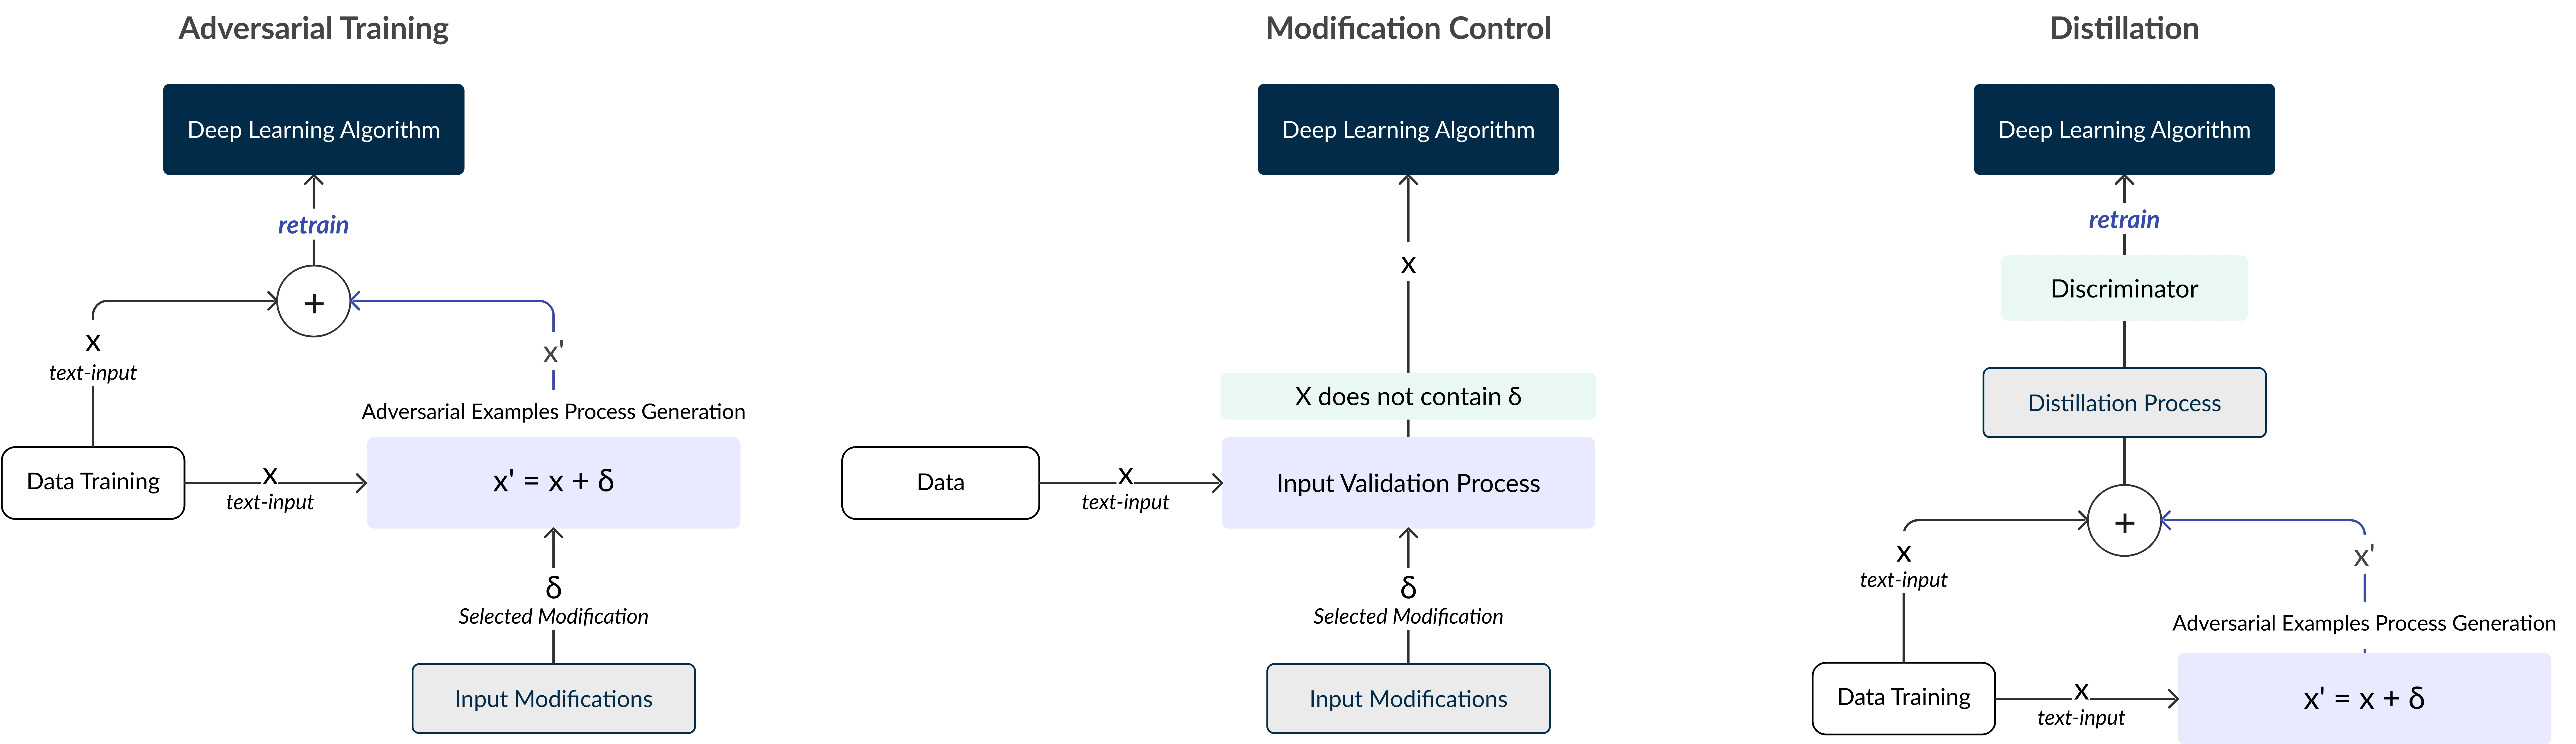

**Problem**


---

Although existing defenses have contributed to maintaining correct model results, they depend on modification process knowledge. The dependence on modification knowledge results in a reduction of generality and a decrease in their effectiveness to maintain model results.

In face of adversarial examples, the key factor for an effective defense is generality, because it is not possible to cover all possible modifications given that new vulnerabilities are constantly being discovered. Therefore, we consider that adversarial defenses should be more general, and in contrast to current defenses, establish a validation process to validate the authenticity and integrity of the inputs before they are processed by the model

Proposal
---



Preventive Defense Mechanism

---



We propose a two-step preventive defense mechanism to achieve an attack-independent defense. The preventive defense scheme include two principal process: 1) a watermarking process to include a mark to inputs model and 2) an input validation process to validate that inputs contain the marked input characteristics before they are processed by the model.

***Hypothesis***

By determining the authenticity and integrity of text-inputs, it is possible to define modification process-independent defenses that exhibit greater generality across different modifications, contributing to maintaining correct results in face of different adversarial attacks.

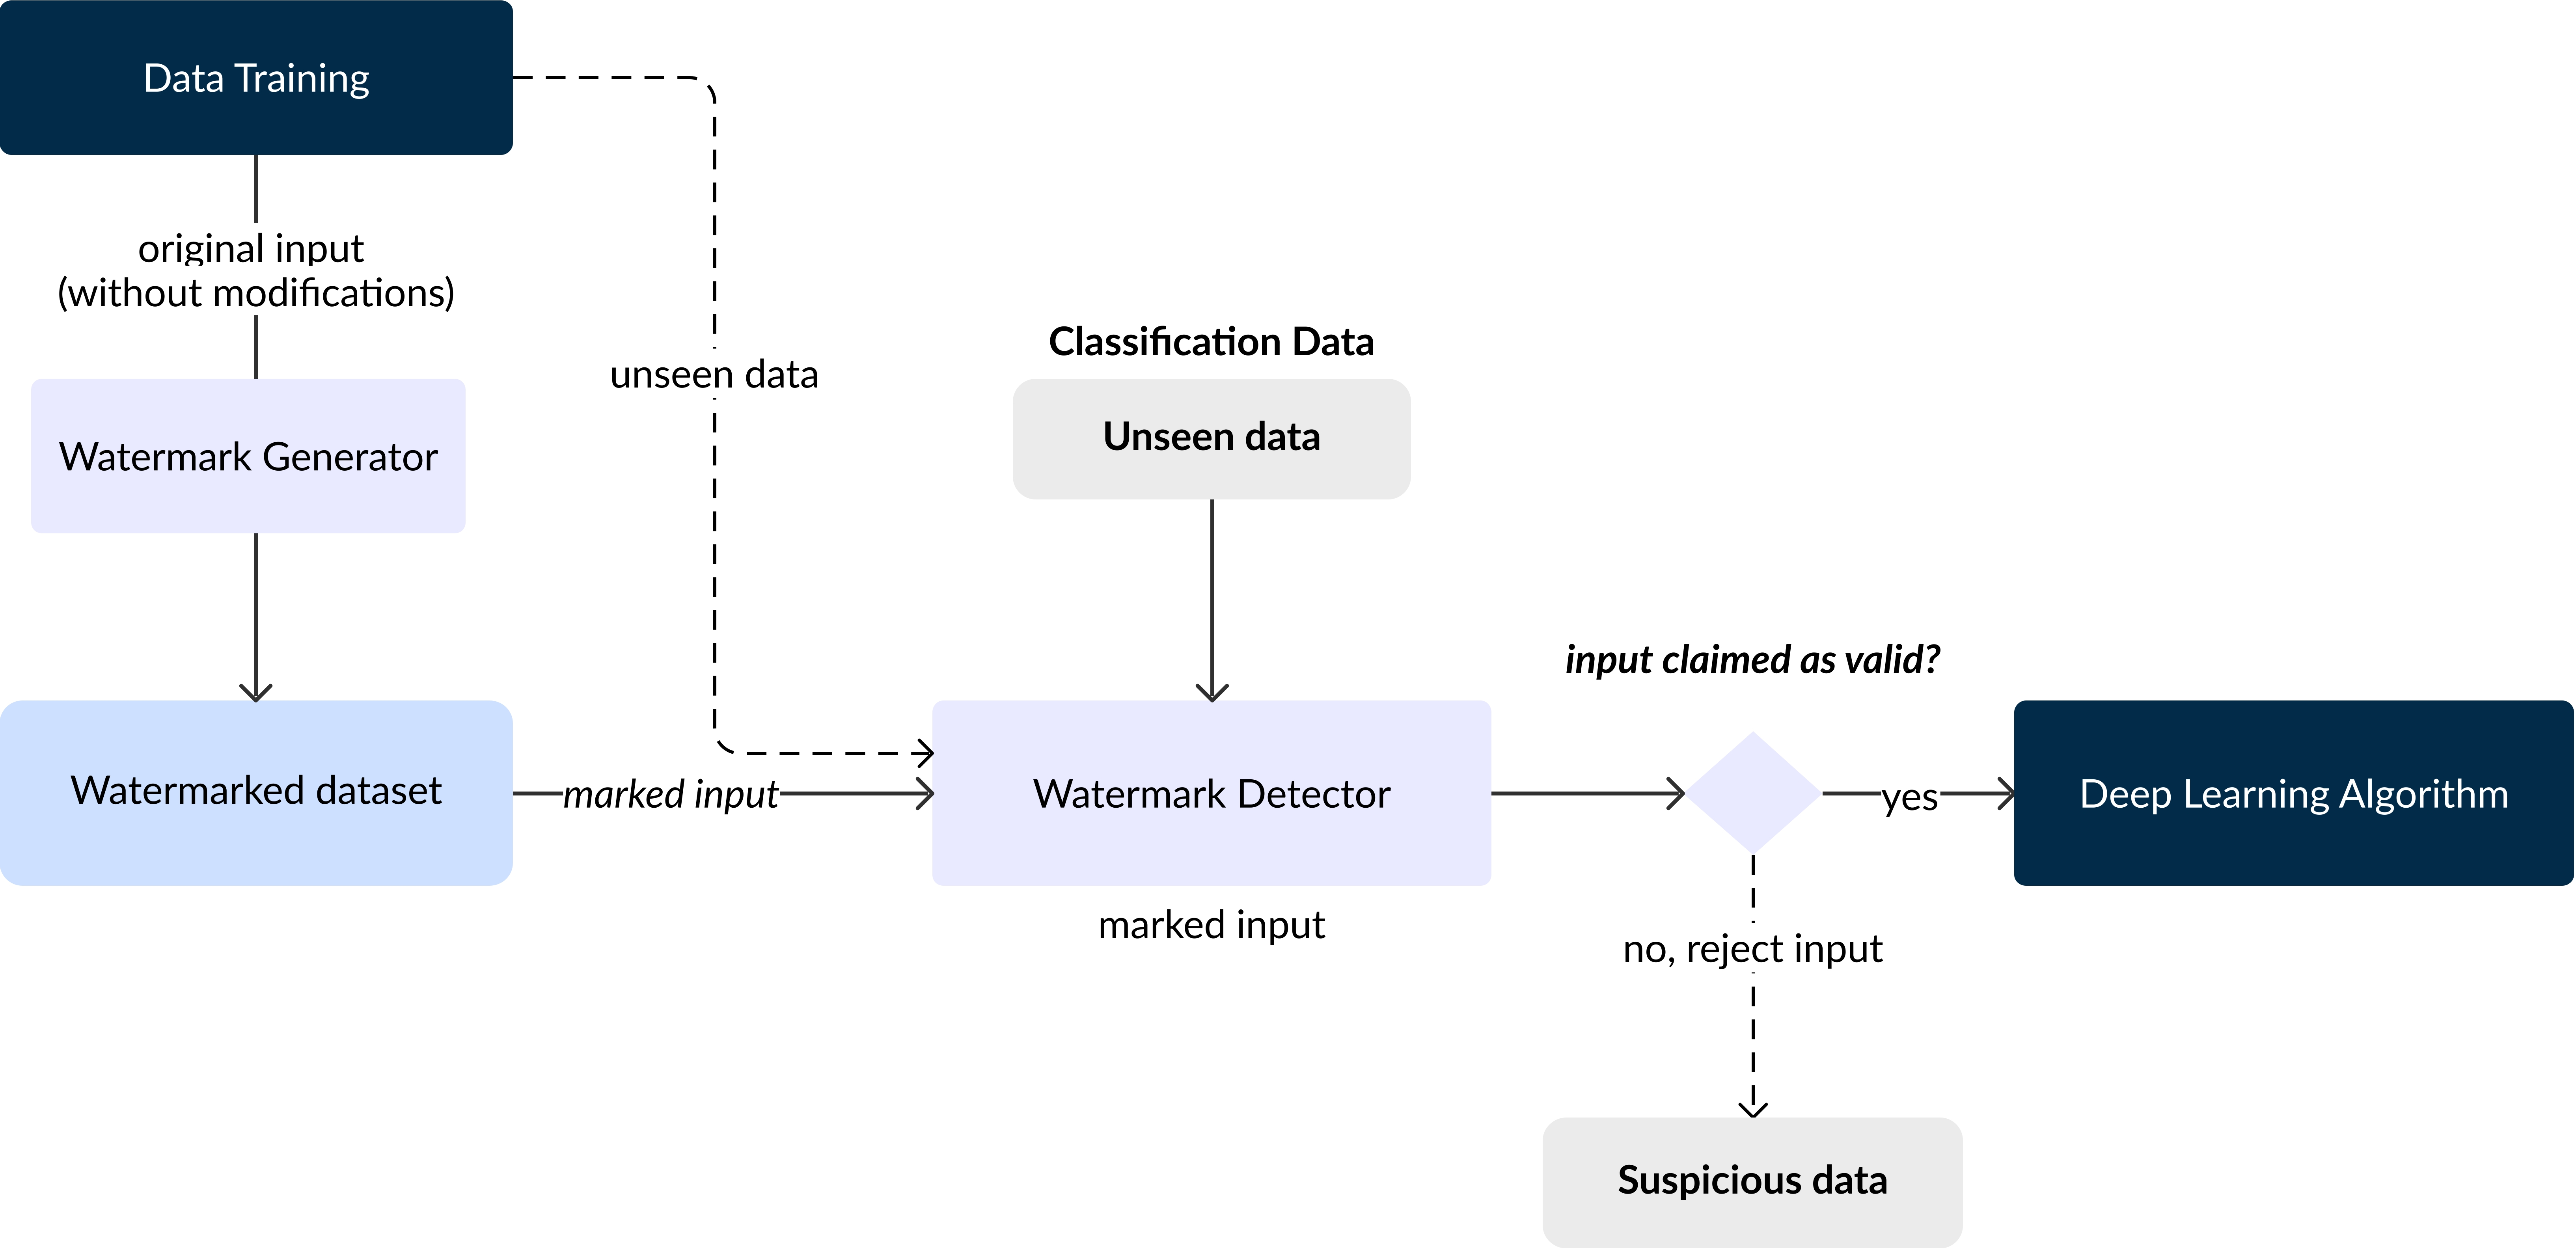

Watermarking process

---





To protect the integrity of inputs, the watermarking process embeds a watermark to input on a hierarchical scheme at sentence and term level applying hash tables and hash functions using a particular key for this process.

**Hashing sentence**

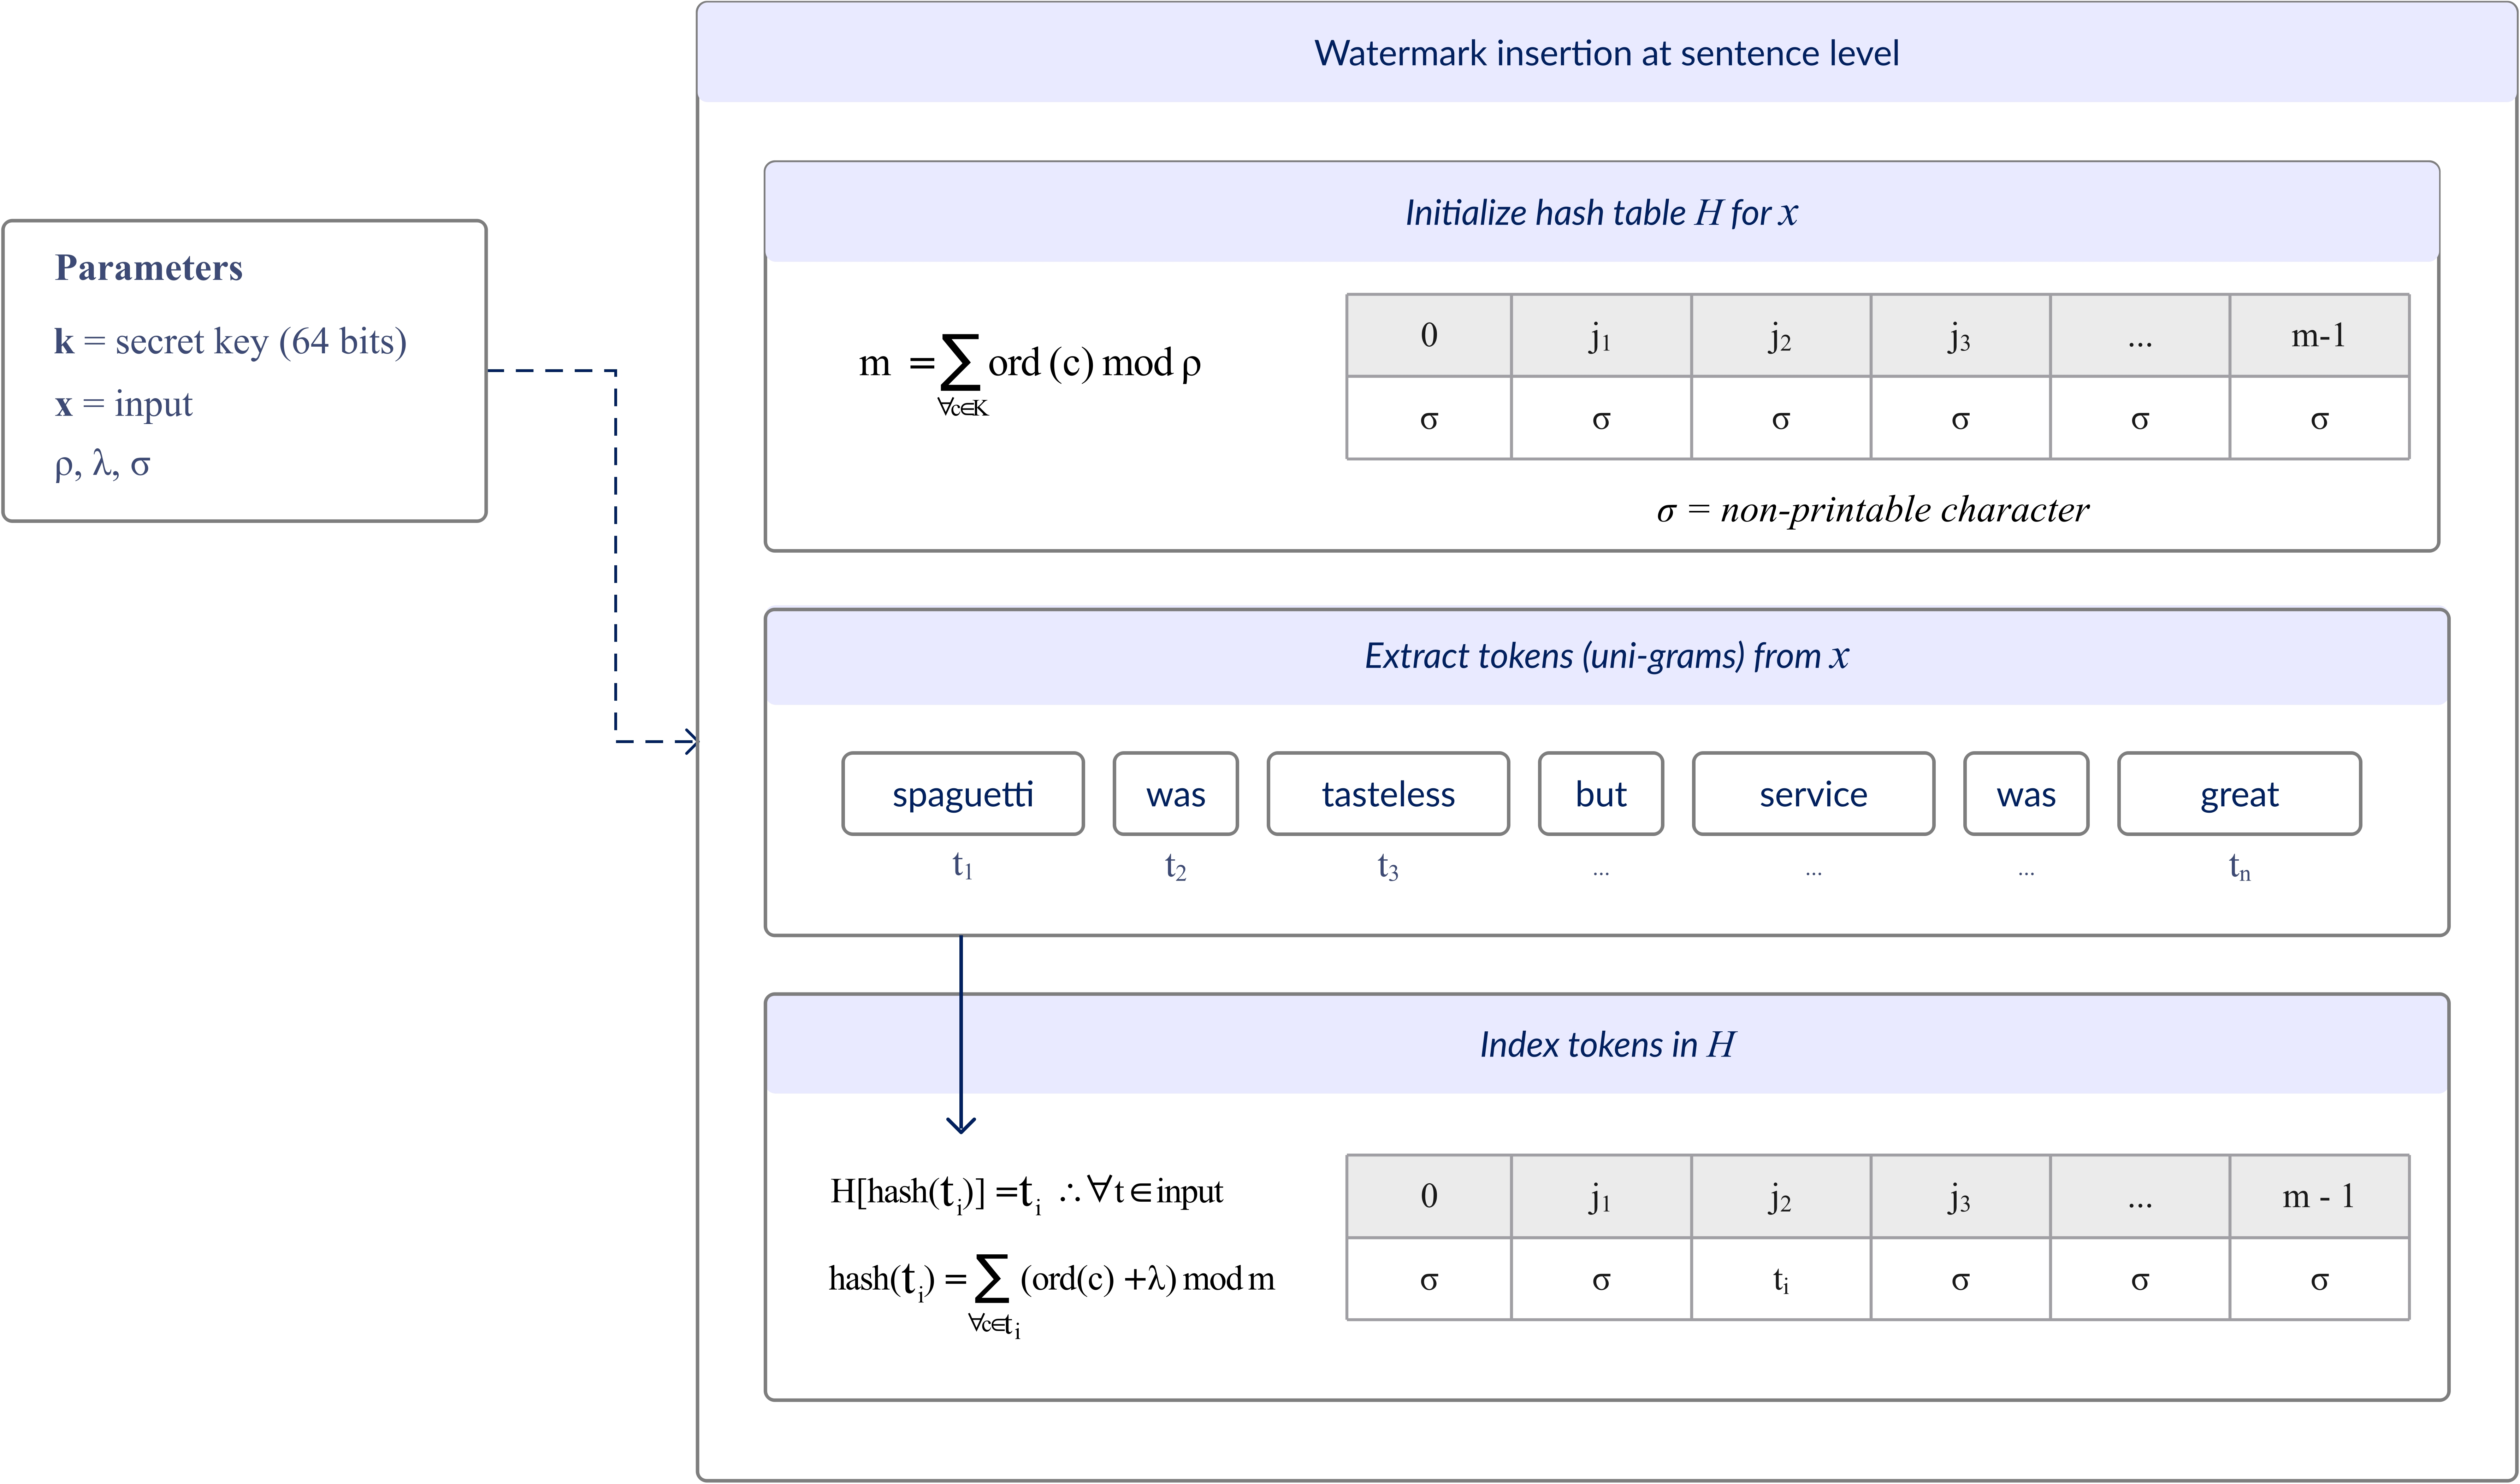

**Hashing term**

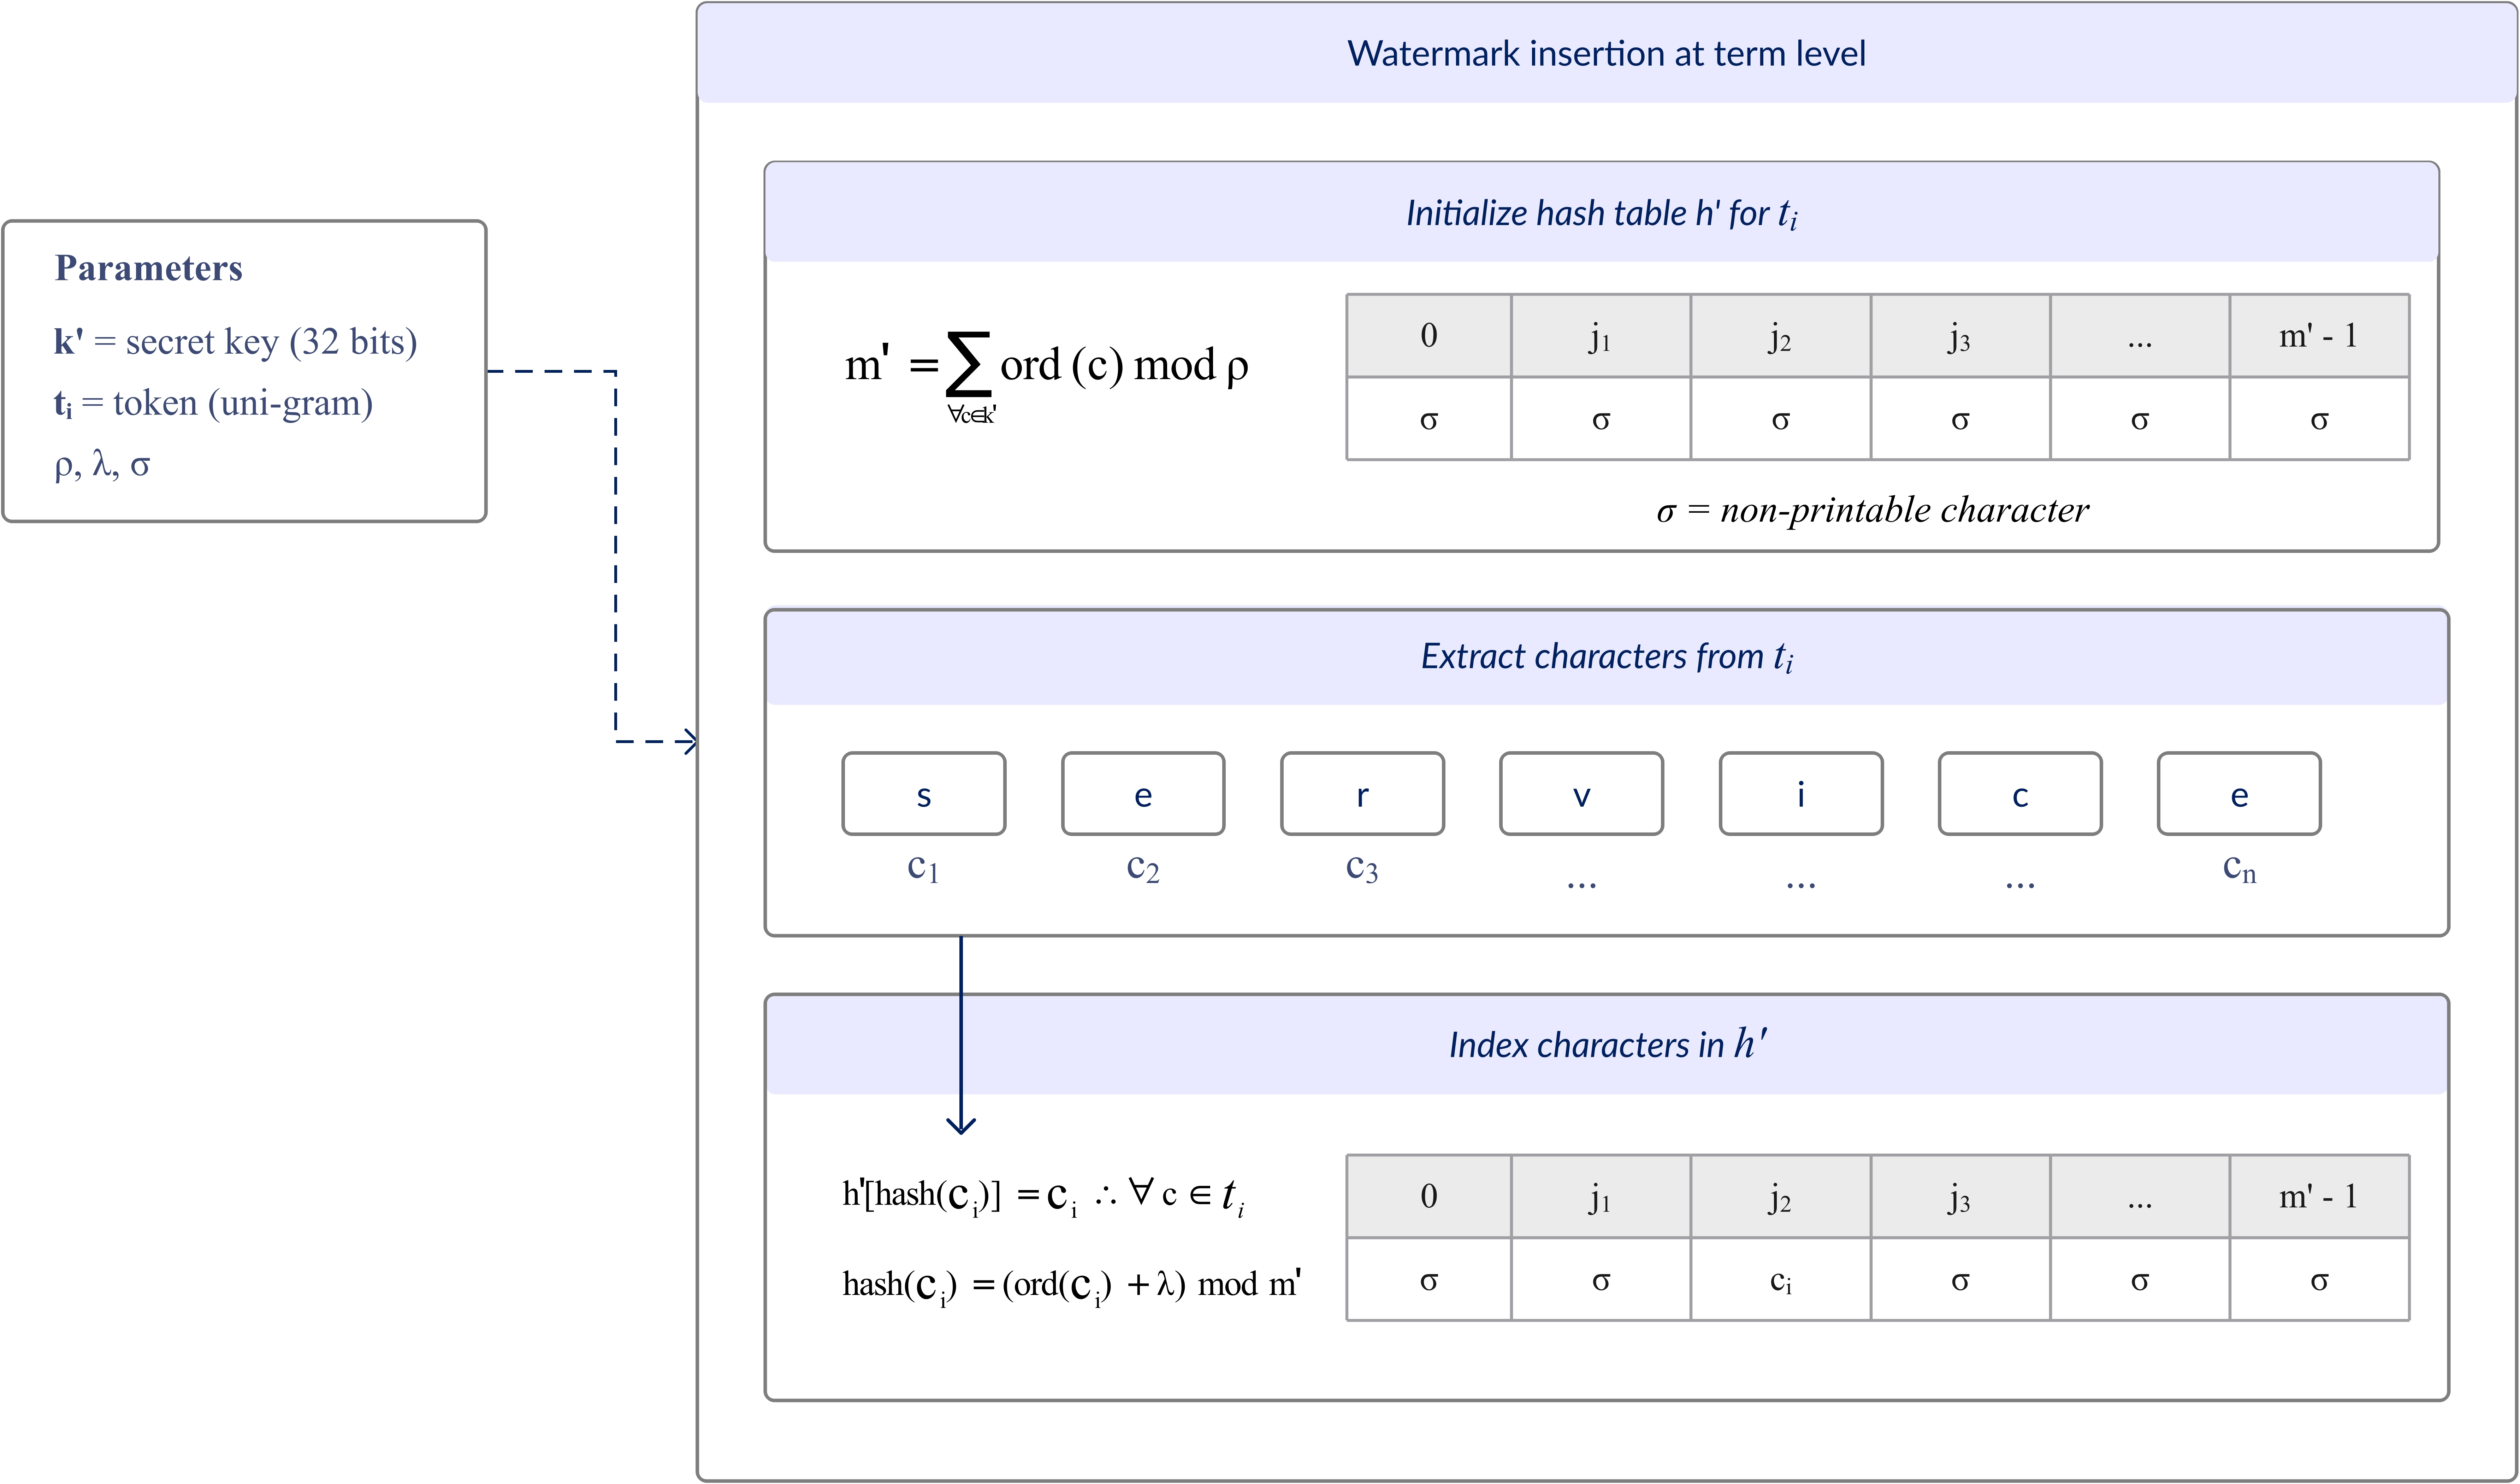

**Dependencies and utilities**
---



In [1]:
"""
Dependencies and utilities for the watermarking / integrity pipeline.

- NLTK: stopword resources for optional text preprocessing.
- hashlib: cryptographic hashing primitives (e.g., SHA-256) for digests/checksums.
- functools.reduce: functional-style reductions (useful for fold-based aggregations).
- time: benchmarking / timing utilities.
- random: non-cryptographic randomness (ONLY for experiments; do not use for secrets).
"""

import time
import random
import hashlib
from functools import reduce
from typing import Iterable
from typing import List, Optional
import re
import unicodedata

import nltk
from nltk.corpus import stopwords

# Download required NLTK resources (idempotent: safe to call multiple times).
# Tip: In production, prefer handling this outside runtime (e.g., in setup scripts).
nltk.download("stopwords")

# Load stopword list once (example: English). Adjust language as needed.
# Example usage:
#   STOP_WORDS = set(stopwords.words("english"))
STOP_WORDS = set(stopwords.words("english"))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
pip install Crypto

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 kB 11.2 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
def CleanReview(text: str) -> str:
    """
    Normalize and sanitize a textual input prior to watermark insertion
    or integrity analysis.

    This function performs deterministic preprocessing to ensure that
    equivalent textual variants map to a stable canonical representation.
    Such normalization is critical in cryptographic or hash-based pipelines,
    where minor orthographic differences may propagate into divergent digests.

    Operations performed:
    - Lowercasing
    - Removal of special placeholders
    - Unicode normalization (accent stripping)
    - Replacement of punctuation with whitespace
    - Collapse of repeated spaces

    Parameters
    ----------
    text : str
        Raw input sentence or review.

    Returns
    -------
    str
        Canonicalized textual representation.
    """

    # ---- Lowercase normalization ----
    text = text.lower()

    # ---- Remove task-specific placeholders ----
    text = text.replace("$t$s", " ").replace("$t$", " ")

    # ---- Unicode normalization ----
    # Converts accented characters into ASCII equivalents.
    text = unicodedata.normalize("NFKD", text)
    text = "".join(char for char in text if not unicodedata.combining(char))

    # ---- Replace punctuation and special symbols ----
    # Using regex is significantly more efficient than chained replace calls.
    text = re.sub(r"[^\w\s]", " ", text)

    # ---- Normalize whitespace ----
    text = re.sub(r"\s+", " ", text).strip()

    return text

In [3]:
"""
Character-level resources for controlled perturbation experiments.

These structures define deterministic mappings that can be used to
simulate keyboard-like character substitutions and identify tokens
eligible for modification during adversarial evaluation.

IMPORTANT:
- These mappings are NOT cryptographically secure.
- Intended strictly for experimental perturbation generation.
"""

from typing import Dict, Set


# ------------------------------------------------------------------
# Character substitution map
# Simulates plausible typographical errors (keyboard proximity).
# ------------------------------------------------------------------
dict_character_errors: Dict[str, str] = {"a": "s",
    "b": "n",
    "c": "v",
    "d": "f",
    "e": "r",
    "f": "g",
    "g": "h",
    "h": "j",
    "i": "o",
    "j": "k",
    "k": "l",
    "l": "o",
    "m": "n",
    "n": "m",
    "o": "p",
    "p": "o",
    "q": "w",
    "r": "t",
    "s": "d",
    "t": "y",
    "u": "i",
    "v": "b",
    "w": "e",
    "x": "c",
    "y": "u",
    "z": "c",
}

# ------------------------------------------------------------------
# Special characters to exclude from perturbation
# Using a set improves O(1) membership checks.
# ------------------------------------------------------------------

SPECIAL_CHARACTERS: Set[str] = {
    ",", "!", ":", "(", ")", ".", '"', "?", "¿", "¡",
    "<", "+", ">", "’", "º", "[", "]", "%", "/", "$",
    "€", "*", "-", "_", "á", "é", "í", "ó", "ú",
    "'", ";", "@", "=",
    "0", "1", "2", "3", "4", "5", "6", "7", "8", "9",
}

# ------------------------------------------------------------------
# Allowed lowercase alphabet
# Useful when restricting perturbations to valid lexical units.
# ------------------------------------------------------------------
ALPHABET: Set[str] = set("abcdefghijklmnopqrstuvwxyz")

In [ ]:
def derive_key_from_corpus(x_train: Iterable[str]) -> str:
  """
  Derive a deterministic cryptographic key from a reference corpus.

  This function aggregates a collection of training sentences into a
  single canonical textual representation and derives a fixed length
  digest using SHAKE-256. The resulting key can be used to parameterize
  watermark insertion or integrity mechanisms in a reproducible manner.

  IMPORTANT:
  - This key derivation is intended for experimental reproducibility.
  - It is NOT a replacement for standard cryptographic key management.
  - Any change in corpus content or preprocessing will change the key.

  Parameters
  ----------
  x_train : Iterable[str]
      Collection of raw training sentences used as reference material.

  Returns
  -------
  str
      Hexadecimal digest derived from the corpus.
  """

  # Initialize extendable-output hash function (XOF)
  hasher = hashlib.shake_256()

  # Concatenate canonicalized sentences into a single string
  # A space separator is used to preserve sentence boundaries
  canonical_corpus = reduce(
      lambda acc, sent: acc + " " + CleanReview(sent),
      x_train
  )

  # Update hash state with UTF-8 encoded corpus
  hasher.update(canonical_corpus.encode("utf-8"))

  # Return a fixed-length hexadecimal digest (64 hex characters)
  return hasher.hexdigest(64)

In [ ]:
import hashlib

def derive_key_from_instance(instance: str) -> str:
  """
  Derive a deterministic cryptographic digest from a single textual instance.

  This function computes a fixed-length hexadecimal digest using SHAKE-256
  over a UTF-8 encoded input string. The resulting digest can be used as
  instance-level evidence in watermarking or integrity-verification pipelines.

  IMPORTANT:
  - This operation is deterministic: identical inputs yield identical digests.
  - The digest length is fixed for comparability across instances.
  - This function does NOT perform canonicalization; callers must ensure
    that the input has already been normalized if stability is required.

  Parameters
  ----------
  instance : str
      Input sentence or textual instance.

  Returns
  -------
  str
      Hexadecimal digest representing the instance.
  """

  # Initialize extendable-output hash function (XOF)
  hasher = hashlib.shake_256()

  # Update hash state with UTF-8 encoded instance
  hasher.update(instance.encode("utf-8"))

  # Return a fixed-length hexadecimal digest (32 hex characters)
  return hasher.hexdigest(32)


In [ ]:
def hash_function_instance(instance_, m):
  """
    Build a sentence-level watermark string by (i) selecting token slots via a hash table
    and (ii) embedding a term-level watermark for the selected tokens in order.

    Core idea:
    - Construct a length-m slot table that marks which positions will carry a token watermark.
    - Resolve collisions by placing marks in the first available empty slot (linear scan).
    - For each marked slot, append a term-level watermark (via `hash_function_term`).
      For each unmarked slot, append an invisible separator character (U+180E).

    Parameters
    ----------
    instance : str
        Input sentence (space delimited tokens).
    m : int
        Number of slots in the instance hash table.

    Returns
    -------
    str
        Watermarked sentence representation composed of invisible fillers and
        hashed-term payloads (space delimited).
  """

  # ----------------------------
  # Initialize instance hash table H
  # ----------------------------
  tabla_hash_instance: List[Optional[int]] = [None for _ in range(m)]

  tokens = instance_.split()

  # ----------------------------
  # Mark slots based on token content and token index
  # ----------------------------
  token_index = 0
  for token in tokens:
    token_index += 1  # 1-based index, as in the original code
    slot = sum((ord(ch) + token_index) for ch in token) % m

    # Collision handling:
    # - If the computed slot is empty, mark it.
    # - Otherwise, mark the first available empty slot (linear scan).
    if tabla_hash_instance[slot] is None:
      tabla_hash_instance[slot] = 1
    else:
      for i in range(len(tabla_hash_instance)):
        if tabla_hash_instance[i] is None:
          tabla_hash_instance[i] = 1
          break


  # ----------------------------
  # Determine the maximum token length for sizing term-level hashing
  # ----------------------------
  max_length_term = max((len(t) for t in tokens), default=0)

  # Instance-derived key/digest (SHAKE-256 hex string)
  k_inst = derive_key_from_instance(instance_)

  # Derive m_terms from the instance digest and max token length.
  # (Preserves original logic; guard against max_token_len == 0 to avoid ZeroDivisionError.)
  if max_length_term == 0:
    m_terms = 0
  else:
    digest_sum = sum(ord(ch) for ch in k_inst)
    m_terms = max_length_term if digest_sum %max_length_term < max_length_term else digest_sum % max_length_term


  # ----------------------------
  # Construct the sentence-level watermark string
  # ----------------------------
  wm_sentence = ""
  token_ptr = -1

  for mark in tabla_hash_instance:
    if mark is None:
      # Invisible filler used to preserve slot structure
      wm_sentence += "\u180e"  # U+180E MONGOLIAN VOWEL SEPARATOR
    else:
      token_ptr += 1
      wm_sentence += hash_function_term(tokens[token_ptr], m_terms) + " "

  return wm_sentence

In [ ]:
from operator import index

def hash_function_term(term_, m_term):
  """
  Build a term-level watermark string by selecting character positions via a hash table.

  Core idea:
  - Construct a length-m_term slot table that marks which positions will carry a character.
  - Each character is mapped to a slot using (ord(char) + 1-based index) mod m_term.
  - Collisions are resolved by placing the mark in the first available empty slot (linear scan).
  - For each marked slot, emit the next character of the term in order.
    For each unmarked slot, emit an invisible filler (U+180E).

  Notes:
  - This function does NOT modify character order: selected characters are emitted sequentially.
  - If m_term < len(term), collisions will occur frequently (by design), and the linear scan
    strategy determines which slots are ultimately marked.

  Parameters
  ----------
  term : str
      Input token/term whose characters are used to generate term-level evidence.
  m_term : int
      Number of slots in the term hash table.

  Returns
  -------
  str
      Watermarked term representation composed of invisible fillers and original characters.
  """

  # Guard against invalid table sizes to prevent ZeroDivisionError.
  if m_term <= 0:
    return ""

  # ----------------------------
  # Initialize term hash table h
  # ----------------------------
  tabla_hash_term: List[Optional[int]] = [None for _ in range(m_term)]

  # ----------------------------
  # Mark slots based on character content and character index
  # ----------------------------
  char_index = 0
  for ch in term:
    char_index += 1  # 1-based index, as in the original code
    slot = (ord(ch) + char_index) % m_term

    # Collision handling:
    # - If the computed slot is empty, mark it.
    # - Otherwise, mark the first available empty slot (linear scan).
    if tabla_hash_term[slot] is None:
      tabla_hash_term[slot] = 1
    else:
      for i in range(len(tabla_hash_term)):
        if tabla_hash_term[i] is None:
          tabla_hash_term[i] = 1
          break

  # ----------------------------
  # Emit watermark string: fillers for empty slots, sequential characters for marked slots
  # ----------------------------
  term_wm = ""
  char_ptr = -1

  for mark in tabla_hash_term:
    if mark is None:
      term_wm += "\u180e"  # U+180E MONGOLIAN VOWEL SEPARATOR (invisible filler)
    else:
      char_ptr += 1
      term_wm += term[char_ptr]

  return term_wm

In [ ]:
def validate_instance(instance_wm: str, m_instances: int) -> bool:
  """
    Validate a sentence-level watermark by regenerating the expected watermark
    from a canonicalized (de-watermarked) version of the instance and comparing
    both representations.

    Validation pipeline:
    1) Remove invisible filler characters / watermark spaces from the received instance.
    2) Recompute the watermark for the cleaned instance using the same parameters.
    3) Compare the received and recomputed watermarks (full string + term-level + char-level).

    Parameters
    ----------
    instance_wm : str
        The watermarked instance to validate (may contain invisible fillers).
    m_instances : int
        Number of slots used during instance-level watermark generation.

    Returns
    -------
    bool
        True if the watermark is valid under exact matching; otherwise False.
  """

  # 1) Canonicalize by removing invisible fillers / watermark spacing artifacts
  cleaned_instance = eliminate_spaces(instance_wm)

  # 2) Recompute the expected watermark for the cleaned instance
  expected_wm = hash_function_instance(cleaned_instance, m_instances)

  # 3) Validate: full-string equality check (primary criterion)
  if instance_wm != expected_wm:
    return False

  # 3.1) Term-by-term validation (kept for traceability / future diagnostics)
  received_terms = instance_wm.split()
  expected_terms = expected_wm.split()

  # Defensive check: if tokenization diverges, the watermark is invalid
  if len(received_terms) != len(expected_terms):
    return False

  for i in range(len(expected_terms)):
    received_term_wm = received_terms[i]
    expected_term_wm = expected_terms[i]

    # Validate the term watermark matches exactly
    if received_term_wm != expected_term_wm:
      return False

    # Validate character-by-character (kept to preserve original granularity)
    for j in range(len(expected_term_wm)):
      if expected_term_wm[j] != received_term_wm[j]:
        return False

  return True


In [ ]:
def validate_instance_aspect_attack(instance_wm, m_instances):

  #Watermarking validation
  # 1. Clean instance to intentionally remove unperceptible white space
  clean_instance_ = eliminate_spaces(instance_wm)

  # 2. Watermarking the clean instance
  instance_wm_ = hash_function_instance(clean_instance_, m_instances)

  # 3. Compare the instance from dataset and the watermarked clean instance
  # print("Valid" if instance_wm == instance_wm_ else "Invalid")

  # # 3.1 Validate term by term
  validate_ = False

  if instance_wm == instance_wm_:
    validate_ = True
    for i in range(len(instance_wm_.split())):

      #Validate space in the correct position by term
      term_wm = instance_wm.split()[i]
      term_wm_ = instance_wm_.split()[i]

      if term_wm == term_wm_:
        validate_ = True

        # Validate character by character
        for j in range(len(term_wm_)):
          if term_wm_[j] == term_wm[j]:
            validate_ = True
          else:
            validate_ = False
            break
      else:
        validate_ = False
        break
  else:
    validate_ = False

  return validate_

In [ ]:
def eliminate_spaces(instance_wm: str) -> str:
  """
  Remove invisible watermark filler characters from a watermarked sentence
  and reconstruct a clean, space-delimited instance.

  This function reverses the structural padding introduced during watermark
  insertion by removing the Mongolian Vowel Separator (U+180E), which is used
  as an imperceptible placeholder to preserve slot alignment.

  Design rationale:
  - Ensures deterministic reconstruction prior to re-watermarking.
  - Prevents filler artifacts from propagating into validation hashes.
  - Maintains original token boundaries.

  Parameters
  ----------
  instance_wm : str
      Watermarked sentence containing invisible filler characters.

  Returns
  -------
  str
      Clean sentence without watermark fillers.
  """

  INVISIBLE_FILLER = "\u180e"

  # Remove filler from each token and rebuild the sentence
  cleaned_terms = [
      term.replace(INVISIBLE_FILLER, "")
      for term in instance_wm.split()
  ]

  # Rejoin using a single space to enforce canonical spacing
  return " ".join(cleaned_terms)


In [ ]:
def validate_term(term: str) -> bool:
  # Iterate over characters and validate membership in the allowed alphabet
  for ch in term:
    if ch in ALPHABET:
        return True

  return False

In [ ]:
def cipher(text: str) -> str:
  """
    Generate a deterministic cryptographic digest from an input string
    using the SHAKE-256 extendable-output function (XOF).

    Parameters
    ----------
    text : str
      Input string to hash.

    Returns
    -------
    str
      64-character hexadecimal digest.
  """

  # Initialize the extendable-output hash function
  hasher = hashlib.shake_256()

  # Update hash state with UTF-8 encoded text
  hasher.update(text.encode("utf-8"))

  # Return fixed-length hexadecimal digest
  return hasher.hexdigest(64)

**Evaluation model**
---



Testing model watermarking

---



In [ ]:
from pathlib import Path
from typing import List
import time


# ---------------------------------------------------------------------
# Load training corpus
# ---------------------------------------------------------------------
# NOTE: Prefer Path objects for portability and clarity.
train_path = Path(
    ".../LAPTOP_TRAIN.reviews"
)

# Use a context manager to ensure the file is always closed properly.
with train_path.open("r", encoding="utf-8") as f:
    # Basic normalization (kept consistent with your original behavior):
    # - strip trailing newline
    # - collapse double spaces (single pass, as originally)
    # - lowercase
    x_train: List[str] = [line.replace("\n", "").replace("  ", " ").lower() for line in f]


# ---------------------------------------------------------------------
# Derive corpus-bound parameters for sentence-level watermark insertion
# ---------------------------------------------------------------------
# Maximum number of tokens across instances (used to parameterize table length).
max_length = max((len(s.split()) for s in x_train), default=0)

# Derive a deterministic key from the reference corpus (experimental key derivation).
key_set = derive_key_from_corpus(x_train)

# m_instances: length of the instance hash table
# NOTE: We preserve your modulus-based sizing scheme.
m_instances = sum(ord(ch) for ch in key_set) % max_length if max_length > 0 else 0


# ---------------------------------------------------------------------
# Watermark insertion over the dataset
# ---------------------------------------------------------------------
start_time = time.time()

# Equivalent to your original expression, but clearer:
#   bloque_ = 100% of the dataset size
block_size = len(x_train)

x_train_wm: List[str] = []

for i in range(block_size):
  instance = x_train[i]

  # Generate sentence-level watermark representation
  instance_wm = hash_function_instance(instance, m_instances)

  # Store watermark for later validation / experimentation
  x_train_wm.append(instance_wm)

print("Time elapsed:", round(time.time() - start_time, 4))

Time elapsed: 0.3405


In [ ]:
# Testing model watermarking
doc_train = open('.../LAPTOP_TRAIN_ABAA.reviews.gold','r', encoding='utf-8')

x_train = [item.replace("\n","").replace("  "," ").lower() for item in doc_train]

inicio = time.time()
bloque_ = int(round((100*len(x_train))/100,0))

sentence_process = ""
for i in range(bloque_):
  sentence_ = x_train[i]
  for j in range(len(sentence_.split())):
    sentence_process += sentence_.split()[j]

print("Time elapsed:", round(time.time()-inicio,4))

Time elapsed: 0.0636


In [ ]:
instance_ = "spaghetti was tasteless"
instance_wm = hash_function_instance(instance_, m_instances)

print(instance_wm)

for term in instance_wm.split():
  print(term)
  index_ = 1
  for char in term:
    print(index_, char)
    index_ += 1
  print("-----------------------------")

In [ ]:
# Testing model validation
doc_train = open('.../LAPTOP_TRAIN_ABAA.reviews.gold','r', encoding='utf-8')

x_train = [item.replace("\n","").replace("  "," ").lower() for item in doc_train]

#Max lenght of reviews - it will be used to set the hash table instance's lenght
max_length = max([len(s.split()) for s in x_train])

# k: 64-bit key
# (for our experimentation the key is defined under the SHAKE-256 algorithm using the dataset to which the input corresponds)
key_set_ = (derive_key_from_corpus(x_train))

#m_instances: lenght of table_hash_instance
m_instances = sum([ord(c_) for c_ in key_set_])%max_length

inicio = time.time()
for instance_wm in x_train_wm:
  validate_ = validate_instance(instance_wm, m_instances)

print("Time elapsed:", round(time.time()-inicio,4))

Time elapsed: 1.5978


**Adversarial Attacks to Evaluate Watermarking Process**
---



Adversrial Attack at Character Level

---



In [ ]:
pip install PyMultiDictionary

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.0/325.0 kB 6.6 MB/s eta 0:00:00


In [ ]:
from typing import List

def adversarial_example_character(instance_wm, terms_):
  # ---------------------------------------------------------------------
  # Random selection of terms to modify
  # ---------------------------------------------------------------------
  # Ensure the requested number of terms does not exceed the number of tokens.
  tokens = instance_wm.split()
  terms_ = len(tokens) if terms_ > len(tokens) else terms_

  selected_term_indices: List[int] = []
  candidate_indices = list(range(len(tokens)))

  ctrl_ = 0
  while ctrl_ < terms_ and candidate_indices:
    # Randomly pick an index from the remaining candidates
    random_idx = random.choices(candidate_indices, k=1)[0]

    token_clean = tokens[random_idx].replace("\u180e", "")

    # Select token if:
    # - it has at least 3 visible characters (length > 2)
    # - it has not been selected already
    # - it passes lexical validation (contains at least one alphabet char)
    if len(token_clean) > 2 and random_idx not in selected_term_indices and validate_term(tokens[random_idx]):
      selected_term_indices.append(random_idx)
      ctrl_ += 1

    # Remove the index from future consideration regardless of accept/reject
    candidate_indices.remove(random_idx)

  # ---------------------------------------------------------------------
  # Apply a single-character substitution to each selected term
  # ---------------------------------------------------------------------
  adversarial_terms: List[str] = []

  for i, token in enumerate(tokens):
    if i not in selected_term_indices:
      adversarial_terms.append(token)
      continue

    # Choose a character position eligible for modification:
    # - must not be the invisible filler (U+180E)
    # - must not belong to SPECIAL_CHARACTERS
    # NOTE: this preserves original "retry until valid" behavior.
    ctrl_modification_ = False
    while not ctrl_modification_:
      random_char_idx = random.randint(0, len(token) - 1)
      ch = token[random_char_idx]

      if ch != "\u180e" and ch not in SPECIAL_CHARACTERS:
        ctrl_modification_ = True

    # Apply the predefined substitution mapping at the chosen position.
    # NOTE: This assumes `ch` exists as a key in dict_character_errors,
    # matching original behavior (will raise KeyError otherwise).
    modified_chars = []
    for j, ch_j in enumerate(token):
      if j == random_char_idx:
        modified_chars.append(dict_character_errors[ch_j])
      else:
        modified_chars.append(ch_j)

    adversarial_terms.append("".join(modified_chars))

  # Reconstruct the adversarial example with canonical single-space separation
  adversarial_example = " ".join(adversarial_terms)

  return adversarial_example

Adversarial Attack at Term Level - Replace by Synonym

---



In [ ]:
from gensim.models import Word2Vec
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors

In [ ]:
#Libraries for synonym information
import requests
import operator
import nltk
nltk.download('wordnet')
nltk.download('omw')
nltk.download('omw-1.4')
import random
from nltk.corpus import wordnet
from numpy import dot
from scipy.special import logsumexp
from numpy.linalg import norm
# nltk.download('all')

from PyMultiDictionary import MultiDictionary
#------------------------------------------

#Clases
class TSinonimos:
  def __init__(self,termino, sinonimo):
    self.termino_ = termino
    self.sinonimo_ = sinonimo

def cosine_distance(u,v):
    # print(u, v)
    # """ Returns the cosine of the angle between vectors v and u. This is equal to uv / |u||v|. """
  return dot(u,v)/(logsumexp(norm(u)*norm(v))) if not (len(u) == 0 or len(v) == 0) else 0

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
"""Twitter"""
word2vec_output_file = '.../glove.twitter.27B.200d.txt.word2vec'
model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)
embedding_size = 200

In [ ]:
def synomym(term_):
  #English
  sinonimos = dict()
  if term_ in model:
    for syn in wordnet.synsets(term_):
      # print(syn.lemma_names())
      for name in syn.lemma_names():
        if name in model and name != term_:
          # aleatory
          # print(name)
          # print(model[termino])
          # print(cosine_distance(model[termino],model[name]))
          # cosine = cosine_distance(model[termino],model[name])

          if cosine_distance(model[term_],model[name]) > 0:
            sinonimos[name] =  cosine_distance(model[term_],model[name])

    if len(sinonimos) > 0:
      # Instrucción para tener el máximo valor de un diccionario
      # key, value = random.choice(list(sinonimos.items()))
      # return key

      # Instrucción para tener el máximo valor de un diccionario
      max_key = max(sinonimos, key = sinonimos.get)
      return max_key
    else:
      return term_
  else:
    return term_

In [ ]:
def adversarial_example_synomym(instance_wm, terms_):

  # Randomly selection of terms to modify
  terms_ = len(instance_wm.split()) if terms_ > len(instance_wm.split()) else terms_
  # print(terms_)
  ctrl_ = 0
  term_list_ = []

  index_items_ = [n for n in range(len(instance_wm.split()))]

  while ctrl_ < terms_ and len(index_items_) > 0:
    random_term_ = random.choices(index_items_, k=1)[0]

    if len(instance_wm.split()[random_term_].replace("\u180e","")) > 2 and random_term_ not in term_list_ and validate_term(instance_wm.split()[random_term_]):
      term_list_.append(random_term_)
      index_items_.remove(random_term_)
      ctrl_ = ctrl_ + 1
    else:
      index_items_.remove(random_term_)

  #############################################################
  last_term_ = len(instance_wm.split())
  adversarial_example = ""

  for i in range(len(instance_wm.split())):
    if i in term_list_:
      term_ = instance_wm.split()[i].replace("\u180e","")
      modified_term = synomym(term_)
      adversarial_example += modified_term + (" " if i < last_term_ else "")
    else:
      adversarial_example += instance_wm.split()[i] + (" " if i < last_term_ else "")



  return adversarial_example

Aspect-Based Adversarial Attack

---



In [ ]:
pip install pyss3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 13.4 MB/s eta 0:00:00


In [ ]:
from pyss3 import SS3
from pyss3.util import Dataset, Evaluation, span
import numpy as np
import math
clf = SS3()

In [ ]:
#------------------------------------------------------------------------
#Test opinions
opinion_train = open('.../S3_EN_LAPTOPS_TRAIN_ABAA.reviews.gold','r', encoding='utf-8')
x_train = [opinion.replace("\n","") for opinion in opinion_train]
opinion_train.close()


#Aspects by opinion in training dataset
aspect_train = open('.../S3_EN_LAPTOPS_TRAIN_ABAA.aspects.gold','r', encoding='utf-8')
a_train = [aspect.replace("\n","") for aspect in aspect_train]
aspect_train.close()

#Polarity-sentiment by aspect in training dataset
polarities_ = []
polarities_train = open('.../S3_EN_LAPTOPS_TRAIN_ABAA.polarities.gold','r', encoding='utf-8')
p_train = [polarity.replace("\n","") for polarity in polarities_train]
polarities_train.close()

for pol in p_train:
  if not pol in polarities_:
    polarities_.append(pol)

print(polarities_)
print(len(x_train))

#------------------------------------------------------------------------
#Test opinions
opinion_test = open('.../S3_EN_LAPTOPS_TEST_ABAA.reviews.gold','r', encoding='utf-8')
x_test = [opinion.replace("\n","") for opinion in opinion_test]
opinion_test.close()


#Aspects by opinion in test dataset
aspect_test = open('.../S3_EN_LAPTOPS_TEST_ABAA.aspects.gold','r', encoding='utf-8')
a_test = [aspect.replace("\n","") for aspect in aspect_test]
aspect_test.close()

#Polarity-sentiment by aspect in training dataset
polarities_test = open('.../S3_EN_LAPTOPS_TEST_ABAA.polarities.gold','r', encoding='utf-8')
p_test = [polarity.replace("\n","") for polarity in polarities_test]
polarities_test.close()

print(len(x_test))

In [ ]:
negative_lexicon = ['terrible', 'tiny', 'bland', 'rude', 'below', 'incredibly', 'doesnt', 'undercooked', 'salty', 'waiting', 'worst', 'promised', 'lacked', 'loud', 'besides', 'poorly', 'seasoning', 'inedible', 'barely', 'horribly', 'awful', 'containers', 'tasteless', 'canned', 'lousy', 'orders', 'watery', 'wont', 'bacon', 'subpar', 'ignored', 'patrons', 'charged', 'morning', 'edible', 'pathetic', 'nite', 'minute', 'buns', 'seem', 'noise', 'middle', 'conversation', 'bacos', 'molars', 'absurdly', 'arrogant', 'recognize', 'glorified', 'clumsy', 'lentil', 'edibility', 'basmati', 'deliver', 'parm', 'boxed', 'tight', 'turns', 'sauces', 'melted', 'disappointing', 'competent', 'crappy', 'level', 'noisy', 'unfortunately', 'frying', 'consisted', 'hurt', 'corridor', 'sugar', 'stay', 'complained', 'mess', 'reason', 'fill', 'bone', 'brought', 'flavorless', 'deliveries', 'skip', 'stale', 'asking', 'drawback', 'coat', 'weak', 'stuck', 'lumpy', 'sketchy', 'consisent', 'barbecued', 'codfish', 'gorgeously', 'poached', 'curiously', 'overwhelmed', 'enhance', 'imitation', 'unnecessarily', 'heated', 'burner', 'compare', 'higher', 'texture', 'utter', 'vegtables', 'oily', 'wanted', 'moist', 'herb', 'trang', 'upper', 'mamouns', 'charging', 'narrow', 'tiled', 'counters', 'stacks', 'cans', 'holding', 'costs', 'proceeded', 'berate', 'condiments', 'explained', 'whatsoever', 'werent', 'everywhere', 'girls', 'overcooked', 'leads', 'bottles', 'needed', 'joint', 'traffic', 'unaccommodating', 'managers', 'note', 'avoid', 'custards', 'kids', 'badly', 'dinnertime', 'category', 'miso', 'downside', 'repeated', 'casserole', 'unfriendly', 'miserable', 'oozing', 'aisle', 'ridiculously', 'mussaman', 'graciously', 'furthermore', 'disgusting', 'irritating', 'acousitcs', 'horrid', 'echoes', 'exorbitant', 'hung', 'edge', 'lanes', 'accurate', 'understands', 'longer', 'saves', 'remorse', 'undoubtedly', 'bottom', 'goes', 'quarters', 'taking', 'fooled', 'hundreds', 'ducasse', 'outshine', 'presentaion', 'terms', 'idea', 'crabmeat', 'changed', 'uncomfortable', 'counted', 'sticky', 'steamy', 'roxy', 'touristy', 'listening', 'explanations', 'bummer', 'portioins', 'arent', 'blasted', 'minimun', 'entranceway', 'drafty', 'later', 'crowds', 'lines', 'tagliatelle', 'fully', 'hated', 'turkey', 'inspired', 'singapore', 'incompetent', 'toaster', 'version', 'knowledge', 'dreadful', 'listen', 'idle', 'engine', 'routinely', 'interrupted', 'servants', 'hinting', 'smell', 'calzone', 'bgel', 'overated', 'icing', 'resembled', 'acted', 'chow', 'excuse', 'ignore', 'female', 'skipped', 'description', 'nazi', 'running', 'complains', 'realtively', 'aesthetics', 'airport', 'stickler', 'rubber', 'thawed', 'longtime', 'holy', 'slipped', 'hesitant', 'disloyal', 'unbearably', 'yeah', 'masses', 'achilles', 'heel', 'leaves', 'scrapped', 'vessel', 'result', 'chunks', 'bowl', 'decreased', 'substantially', 'shipped', 'brunos', 'nonchalant', 'exterminator', 'dismayed', 'apologetic', 'overpowering', 'qualities', 'guess', 'discount', 'pizzerias', 'pies', 'boxes', 'gabriella', 'lies', 'effort', 'dollar', 'neglected', 'chosen', 'recent', 'budget', 'belly', 'pass', 'ambitious', 'frantic', 'weekend', 'wouldve', 'carry', 'notice', 'constantly', 'lounge', 'friendliest', 'increase', 'whats', 'attest', 'bars', 'cake', 'tips', 'alone', 'atomosphere']
positive_lexicon = ['wonderful', 'spot', 'chocolate', 'highly', 'incredible', 'foods', 'yummy', 'reasonably', 'bistro', 'duck', 'interesting', 'beat', 'enjoy', 'tempura', 'awesome', 'happy', 'extensive', 'pastrami', 'perfection', 'setting', 'view', 'casual', 'slice', 'cozy', 'relaxed', 'green', 'vibe', 'outdoor', 'olive', 'affordable', 'relax', 'scallops', 'flavors', 'eggplant', 'evening', 'pastas', 'buffet', 'unlike', 'soups', 'assorted', 'banana', 'homemade', 'notch', 'caviar', 'coming', 'unique', 'accomodating', 'phenomenal', 'theater', 'overbearing', 'otherwise', 'dough', 'tomatoes', 'bombay', 'modern', 'japan', 'professional', 'promptly', 'five', 'avenue', 'lovely', 'serves', 'picks', 'guizhou', 'funky', 'famous', 'particular', 'ceviche', 'presentation', 'eats', 'delighted', 'freshest', 'source', 'samosa', 'seasoned', 'kept', 'crispy', 'frites', 'salt', 'quiet', 'serve', 'spreads', 'pesto', 'alluring', 'featuring', 'sommlier', 'complicated', 'maze', 'captain', 'experiance', 'guest', 'pudding', 'ginger', 'changing', 'paninis', 'early', 'tartare', 'ways', 'wallet', 'diverse', 'potatoes', 'superb', 'spring', 'clean', 'pickles', 'miss', 'youve', 'quickly', 'soothing', 'surprising', 'corned', 'ninas', 'nonsense', 'jelly', 'groups', 'mozz', 'imported', 'flour', 'efficiently', 'specifically', 'palate', 'pleasurable', 'souffle', 'knowledgable', 'dumpling', 'unlimited', 'means', 'loved', 'pinot', 'delightful', 'inludes', 'scrumptious', 'chaat', 'bhelpuri', 'sevpuri', 'chaats', 'spiced', 'zucchini', 'whitefish', 'page', 'nosh', 'wants', 'offers', 'calamari', 'tamarind', 'plenty', 'parmesan', 'fair', 'satisfied', 'oasis', 'refinement', 'somewhat', 'uneven', 'reaches', 'pinnacles', 'passion', 'kitchens', 'precise', 'execution', 'beverage', 'accompanied', 'lasagna', 'deserve', 'barts', 'roti', 'knowledgeable', 'crew', 'treated', 'consistent', 'sausages', 'sardines', 'biscuits', 'pistachio', 'chilaquiles', 'blond', 'gives', 'personable', 'lanterna', 'jalapeno', 'visiting', 'gelato', 'corn', 'massamman', 'actors', 'mashed', 'mixed', 'unexpected', 'bustling', 'wasabi', 'moms', 'chilled', 'unpretensious', 'spider', 'deep', 'varieties', 'dollars', 'forward', 'lets', 'pumkin', 'tortelini', 'joya', 'youd', 'speedy', 'emilio', 'adventurous', 'bruschetta', 'oven', 'appetizing', 'standout', 'flooded', 'vinegar', 'slices', 'chevre', 'marvelous', 'rasberry', 'mint', 'sorbet', 'sensations', 'tapas', 'mesclun', 'havent', 'virgnin', 'greeted', 'gracious', 'offerng', 'complementary', 'bouche', 'celebration', 'carpaachio', 'exellent', 'lady', 'dined', 'diamond', 'herbs', 'west', 'haru', 'prime', 'park', 'south', 'tony', 'fillet', 'cheeses', 'signs', 'menus', 'fluke', 'drizzled', 'fruit', 'nicely', 'highlighting', 'fishs', 'abbys', 'treasure', 'wintermelon', 'covering', 'neapolitan', 'lightly', 'joes', 'bisque', 'rarely', 'stocked', 'melts', 'ground', 'evoked', 'drunken', 'soupy', 'stir', 'spices', 'onions', 'brings', 'upstairs', 'francois', 'appitizers', 'backyard', 'pineapple', 'heart', 'warming', 'candles', 'pictures', 'mahi', 'candlevery', 'grilling', 'delcious', 'peanut', 'vodka', 'criticize', 'thailand', 'toons', 'desert', 'write', 'unheralded', 'impecible', 'magnificant', 'luckily', 'saved', 'leaping', 'lizard', 'prosecco', 'knots', 'nearby', 'clearly', 'mark', 'class', 'true', 'values', 'succulent', 'steaks', 'precisely', 'doneness', 'leafy', 'road', 'kill', 'anti', 'mains', 'expanded', 'advice', 'students', 'young', 'penny', 'near', 'classy', 'cheesecake', 'dals', 'river', 'adequate', 'nicest', 'swordfish', 'nnbrrs', 'surprises', 'juicy', 'starter', 'disney', 'okra', 'bindi', 'options', 'accomodate', 'gulab', 'jamun', 'feet', 'heaven', 'bruschettas', 'tramezzinis', 'stagnating', 'booth', 'privacy', 'seaweed', 'sooo', 'skimp', 'delight', 'buttah', 'wash', 'brick', 'vibrant', 'semi', 'lyles', 'remaining', 'innovations', 'addition', 'magnificent', 'gorgeous', 'beautifully', 'tiem', 'characters', 'clams', 'crafted', 'outrageously', 'dazzling', 'embracing', 'beauty', 'humble', 'root', 'consomme', 'accomplishes', 'fats', 'rose', 'charming', 'selecion', 'godmother', 'fires', 'attended', 'enthusiastic', 'gaskin', 'coffee', 'creatively', 'courteous', 'scallop', 'refreshing', 'wide', 'preparing', 'impress', 'window', 'patio', 'excpetiona', 'cheeseburger', 'delictable', 'perfectly', 'adds', 'donut', 'unusually', 'rock', 'tons', 'classics', 'dinnerbroker', 'codes', 'attitudes', 'companionship', 'regulars', 'fresher', 'thinner', 'crispier', 'occasionally', 'ease', 'families', 'delectable', 'preparation', 'currys', 'masaman', 'chill', 'quail', 'snack', 'wood', 'premium', 'quaint', 'leon', 'lively', 'logic', 'energy', 'alive', 'cannoli', 'primi', 'secondi', 'claims', 'ziti', 'meatsauce', 'kamikaze', 'santa', 'chopped', 'devine', 'sensual', 'mayo', 'hike', 'comforting', 'godfather', 'mortal', 'unimposing', 'shoestring', 'correct', 'tails', 'ummmmm', 'dozen', 'cube', 'ingrediants', 'realy', 'horedevous', 'winnie', 'everytime', 'challah', 'otherworldly', 'knishes', 'yonah', 'schimmels', 'sandwhich', 'heartier', 'appetites', 'caserole']
['blue', 'include', 'meats', 'baby', 'finally', 'yellow', 'tail', 'boton', 'torro', 'urchin', 'assortment', 'boiling', 'sunken', 'surface', 'platters', 'warned', 'okay', 'prosciutto', 'arugula', 'fondue', 'host', 'congee', 'tonic', 'comment', 'read', 'plastic', 'forks', 'hummus', 'filets', 'cokes', 'somewhere', 'edamames', 'girl', 'shared', 'ourselves', 'hungry', 'drank', 'himself', 'laying', 'checked', 'impressive', 'orsay', 'carte', 'rapido', 'clear', 'theyre', 'oysters', 'stumbled', 'closer', 'approximately', 'ride', 'conclusion', 'culinary', 'knocking', 'crossed', 'began', 'apples', 'kielbasa', 'load', 'messy', 'yoshi', 'comprised', 'prior', 'hunan', 'crusted', 'slaw', 'described', 'escargot', 'photobook', 'helped', 'blowing', 'nightmare', 'masala', 'jump', 'details', 'excelent', 'recomendations', 'capable', 'occasion', 'ranging', 'peters', 'favourite', 'margarite', 'trout', 'facing', 'gone', 'unable', 'planning', 'replied', 'between', 'added', 'spilled', 'yorkers', 'under', 'lettuce', 'trained', 'caprese', 'changes', 'tuesday', 'larger', 'blend', 'agree', 'serious', 'action', 'chopsticks', 'swirl', 'refleshment', 'crushed', 'grapes', 'overdue', 'mondays', 'ribbon', 'anticipating', 'claiming', 'march', 'flight', 'busier', 'seldom', 'kalbi', 'nebbiolo', 'apetizers', 'devoid', 'katz', 'mexican', 'supplied', 'double', 'previews', 'appreciation', 'expecting', 'cole', 'knish', 'valentines', 'chain', 'slurry', 'crap', 'mill', 'citysearch', 'freeze', 'theyd', 'nnbrrx', 'atlhough', 'awkardly', 'palak', 'kofta', 'fingers', 'subway', 'devoted', 'bannan', 'fritter', 'couteract', 'keeping', 'dinosaur', 'afternoon', 'moderate', 'jefferys', 'gourmet', 'comparison', 'overflowing', 'oyster', 'binge', 'closing', 'glad', 'complain', 'walnuts', 'frequently', 'basically', 'refills', 'agreed', 'orrechiete', 'sausage', 'questions', 'hope', 'present', 'attend', 'moderately', 'comparable', 'treat', 'pancakes', 'vindaloo', 'pound', 'stomach', 'sesame', 'encouraged', 'boldness', 'flavour', 'palette', 'improves', 'paneer', 'standard', 'malai', 'hoping', 'noticed', 'proper', 'favor', 'apology', 'leaving', 'elsewhere', 'soaked', 'concoction', 'cart', 'attendant', 'lotus', 'leaf', 'nearing', 'local', 'thinking', 'hissed', 'varities', 'ripped', 'raucous', 'display', 'lurking', 'myriad', 'marine', 'murky', 'waters', 'creatures', 'harus', 'yourself', 'chop', 'figured', 'megadeth', 'scruff', 'germain', 'songs', 'sabbath', 'daft', 'punk', 'played', 'seltzer', 'whem', 'detailed', 'satisfy', 'pressured', 'incoming', 'gathered', 'accustomed', 'taipei', 'grow', 'advance', 'burned', 'stringy', 'associates', 'mnnbrrpp', 'puree', 'mesh', 'digestive', 'wasting', 'support', 'piped', 'entertain', 'clients', 'fiances', 'happier', 'lean', 'whiff', 'corriander', 'passing', 'sometime', 'client', 'meetings', 'vault', 'arrival', 'lifetime', 'hurry', 'mash', 'happens', 'sixth', 'curtain', 'industry', 'understood', 'nicky', 'nose', 'office', 'nigiri', 'hopefully', 'beaten', 'distract', 'commend', 'california', 'freshwater', 'doors', 'coats', 'thursday', 'soda', 'critic', 'noted', 'weekday', 'lafayette', 'angel', 'famished', 'celebrate', 'mare', 'differently', 'understandable', 'uncourteous', 'downright', 'parched', 'watch', 'attract', 'shockingly', 'contract', 'deposit', 'mezz', 'yasuda', 'reached', 'passed', 'bumped', 'chair', 'spare', 'apps', 'test', 'palets', 'chose', 'info', 'chennai', 'owns', 'typhoon', 'marks', 'chalk', 'sounds', 'costco', 'stike', 'speaking', 'upstate', 'parking', 'specify', 'requested', 'normally', 'improper', 'southern', 'medium', 'coem', 'aunts', 'assuming', 'aunt', 'feels', 'notified', 'apologize', 'decision', 'ottimo', 'fresca', 'easier', 'saet', 'annual', 'christmas', 'members', 'holidays', 'restaraurant', 'squeeze', 'anniversary', 'sticks', 'sample', 'friday', 'minimalist', 'downtown', 'explain', 'deli', 'bought', 'round', 'gotten', 'brilliant', 'split']

neutral_lexicon = []

In [ ]:
def VectorAspect(aspect_):
  terms_ = CleanReview(aspect_).split()
  AVector_ = []
  no_terms = 0
  # print(terms_)
  for term in terms_:
    if term in model:
      if no_terms == 0:
        AVector_ = model[term]
      else:
        AVector_ = np.asarray(AVector_ + model[term])

      no_terms += 1

  #Vector único promedio
  return np.asarray([n * (1/no_terms) for n in AVector_])

In [ ]:
def aspect_based_adversarial_example(instance_wm, i):

  aspect_ = a_train[i]
  polarity_ = p_train[i]
  instance_wm_clean = eliminate_spaces(instance_wm)

  sentiment_lexicon_ = positive_lexicon if polarity_ == "positive" else negative_lexicon if polarity_ == "negative" else neutral_lexicon
  b_ = 0.4
  terms_aspect_ = aspect_.split()
  vector_aspect_ = VectorAspect(aspect_)
  terms_modifiy_ = []
  index_ = 0

  # print(aspect_)
  for term_ in instance_wm.split():
    term_clean_ = term_.replace("\u180e","")

    if len(term_clean_) > 3 and index_ not in terms_modifiy_ and validate_term(term_) and term_clean_ not in terms_aspect_ and term_clean_ in model:
    # if len(term_) > 3 and index_ not in terms_modifiy_ and term_ in sentiment_lexicon_ and validate_term(term_) and term_ not in terms_aspect_ and term_ in model:
      SP_ = cosine_distance(model[term_clean_],vector_aspect_)
      if SP_ >= b_:
        terms_modifiy_.append(index_)

    index_ += 1

  # print(terms_modifiy_)

  terms_to_built_sentence = []
  ctrl_adversarial_example = False
  adversarial_example = ""
  if len(terms_modifiy_) > 0:


    for i in range(len(instance_wm.split())):
      if i in terms_modifiy_:
        modified_term = ""
        ctrl_modification_ = False

        while ctrl_modification_ == False:
          # -1 is to control the out of index
          random_character_ = random.randint(1, len(instance_wm.split()[i])-2)

          if (instance_wm.split()[i][random_character_]) != "\u180e" and (instance_wm.split()[i][random_character_]) not in SPECIAL_CHARACTERS:
            ctrl_modification_ = True


        # print(random_character_)

        for j in range(len(instance_wm.split()[i])):
          char_ = instance_wm.split()[i][j]

          if j == random_character_:
            modified_term += dict_character_errors[char_]
          else:
            modified_term += char_

        # adversarial_example += modified_term #+ ("" if i == last_term_ else " ")
        terms_to_built_sentence.append(modified_term)
      else:
        terms_to_built_sentence.append(instance_wm.split()[i])
        # adversarial_example += instance_wm.split()[i] #+ ("" if i == last_term_ else " ")

    ctrl_adversarial_example = True
    adversarial_example = ""

    for i in range(len(terms_to_built_sentence)):

      if i > 0:
        adversarial_example += " "
      adversarial_example += terms_to_built_sentence[i]

  else:
    adversarial_example = instance_wm
    ctrl_adversarial_example = False

  # for i in range(len(instance_wm.split())):
  #   print(i," ",adversarial_example.split()[i], ":", len(adversarial_example.split()[i])," - ",instance_wm.split()[i],":", len(instance_wm.split()[i]))
  # print(adversarial_example, len(adversarial_example))
  return adversarial_example if ctrl_adversarial_example else instance_wm, ctrl_adversarial_example


Evalutation process against adversarial attack

---



In [ ]:
# Adversarial Attack at Character, Term level
adversarial_dataset_ = []

for i in range(len(x_train_wm)):
# for i in range(500):
  instance_wm = x_train_wm[i]
  if len(instance_wm.split()) > 2:
    # adversarial_dataset_.append(adversarial_example_character(instance_wm,6))
    adversarial_dataset_.append(adversarial_example_synomym(instance_wm,4))
  else:
    adversarial_dataset_.append(instance_wm)


inicio = time.time()
validates_ = 0
no_validates_ = 0
instances_ = 0
errors_ = []
for i in range(len(adversarial_dataset_)):
  instance_ = adversarial_dataset_[i]
  if len(instance_.split()) > 2:
    validate_ = validate_instance(instance_, m_instances)
    # print(validate_)


    if validate_ == True:
      no_validates_ += 1
      instance_wm = x_train_wm[i]

      for j in range(len(instance_)):
        if instance_[j] != instance_wm[j]:
          if not instance_[j] in errors_:
            errors_.append(instance_[j])
    else:
      validates_ += 1
  else:
      validates_ += 1

  instances_ += 1


print("Time elapsed:", round(time.time()-inicio,4))
print("Instances:", instances_)
print("True positive: ", validates_)
print("False positive:", no_validates_)

print("TPR:", round((validates_*100)/instances_,4))
print(errors_ if len(errors_) > 0 else "")



Time elapsed: 0.0988
Instances: 361
True positive:  361
False positive: 0
TPR: 100.0



In [ ]:
# Aspect-Based Adversarial Attack
adversarial_dataset_ = []
adversarial_examples_ = []

for i in range(len(x_train_wm)):
# for i in range(2):
  instance_wm = x_train_wm[i]


  if len(instance_wm.split()) > 2:

    adversarial_example, ctrl_adversarial_example = aspect_based_adversarial_example(instance_wm, i)
    adversarial_examples_.append(ctrl_adversarial_example)

    if ctrl_adversarial_example:

      adversarial_dataset_.append(adversarial_example)
    else:
      adversarial_dataset_.append(instance_wm)
  else:
    adversarial_examples_.append(False)
    adversarial_dataset_.append(instance_wm)



inicio = time.time()
correct_ = 0
incorrect_ = 0
instances_ = 0
errors_ = []

# for i in range(10):
for i in range(len(adversarial_dataset_)):
  ctrl_validation_ = False
  instance_ = adversarial_dataset_[i]
  instance_wm = x_train_wm[i]


  # if adversarial_examples_[i] == True:
# if adversarial_examples_[i] == False:
  if len(instance_.split()) > 2:
    validate_ = validate_instance_aspect_attack(instance_, m_instances)
    # print(validate_, " - ",adversarial_examples_[i])

    if adversarial_examples_[i]:
      # print(instance_)
      # print(instance_wm)

      if validate_ == True:
        incorrect_ += 1
        ctrl_validation_ = True
      else:
        correct_ += 1
    else:
      if validate_ == True:
        correct_ += 1
      else:
        incorrect_ += 1
        ctrl_validation_ = True


    if ctrl_validation_ == True:
      for j in range(len(instance_)):
        if instance_[j] != instance_wm[j]:
          if not instance_wm[j] in errors_:
            errors_.append(instance_wm[j])


  else:
      correct_ += 1


  instances_ += 1


print("Time elapsed:", round(time.time()-inicio,4))
print("Instances:", instances_)
print("True positive: ", correct_)
print("False positive:", incorrect_)

print("TPR:", round((correct_*100)/instances_,4))
print(errors_ if len(errors_) > 0 else "")

Time elapsed: 0.501
Instances: 2328
True positive:  2327
False positive: 1
TPR: 99.957
['y']
